# generating snapshots of creation event (Luo-Rudy model)
Tim Tyree<br>
4.23.2024

In [3]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import skimage as sk
from skimage import measure, filters

from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

# #load the libraries
from lib import *
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *
import shutil
from lib.measure.comp_tips_safely import get_comp_tips
from lib.viewer.DomainPlot import SaveTipsAndColoredContours

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# define module

# load data

In [4]:
# save_folder=f'{nb_dir}/Figures/'
ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
t=0

txt=load_buffer(ic_fn)
ds=5.
frameno=1
# txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
V_threshold=-40
dt=0.1 #supports really long termination time...
diffCoef=0.001#0.0005
Cm=1.0
# comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir=nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=diffCoef,Cm=Cm)
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)


In [5]:
#try to fix the wobble motion by increasing the time between img and img_prev
DT=4 #??
# DT=2 #supported odd numbers of spiral tips briefly
# DT=16 #tips far from apparent tips
#DT=8.#wobbeled
nsteps_per_DT=int(DT/dt)

In [6]:
#comp img_prev example
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
#integrate to t=100 milliseconds
while t<100:
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img_prev=inVc[...,0].copy()
for n in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
img=inVc[...,0].copy();#dimgdt=dVcdt[...,0]

In [9]:
jump_threshold=width/2
size_threshold=0
level1=V_threshold
level2=V_threshold
#compute spiral tip location and topological number
contours_a = find_contours(img,        level = level1)
contours_b = find_contours(img_prev,     level = level2)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)

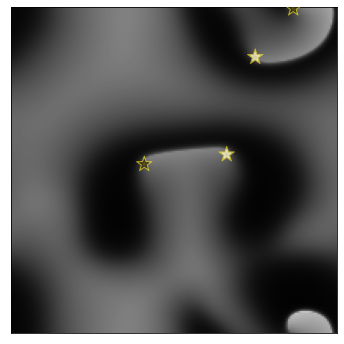

In [11]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[1]=1
c_values[2]=1

retval=ShowDomain(img,img_prev,x_values,y_values,c_values,V_threshold,t,inch=6,
                     fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                     frameno=frameno,
                     save_fn=None,
                     save_folder=None,
                     save=False,
                     annotating=False,
                     axis=[0,img.shape[0],0,img.shape[1]], cmap='bone');

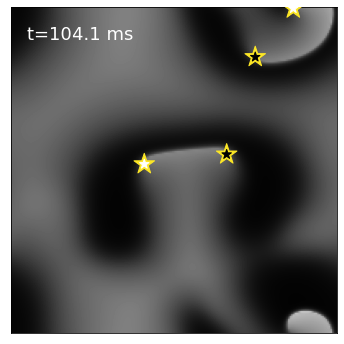

In [23]:
cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
message_string=f'{t=:.1f} ms'
inch=6;
fontsize=18;
vmin_img=-85.;vmax_img=35.
vmin_tips=0.;vmax_tips=1.
message_string
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=470, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=100, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.05,.9,message_string,
        horizontalalignment='left',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)
#     ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [27]:
txt_init = txt.copy()
t_init = float(t)
n_init = len(x_lst)
n_init

4

# identify a list of creation events

In [39]:
#reset time
txt = txt_init.copy()
t = float(t_init)
n = int(n_init)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)

In [40]:
printEnd='\r'

In [41]:
tmax=1000
printing=True
t_lst=[]
n_lst=[]
while t<tmax and n>0:
    img_prev = img
    for step in range(nsteps_per_DT):
        one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
        t+=dt
    img=inVc[...,0].copy()
    #compute spiral tip location and topological number
    contours_a = find_contours(img,        level = level1)
    contours_b = find_contours(img_prev,     level = level2)
    s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
    n = len(x_lst)
    #record
    t_lst.append(t)
    n_lst.append(n)
    print(f"{t=:.1f} ms out of {tmax} ms ({n=})", end = printEnd)

In [46]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
# c_values[1]=1
# c_values[2]=1

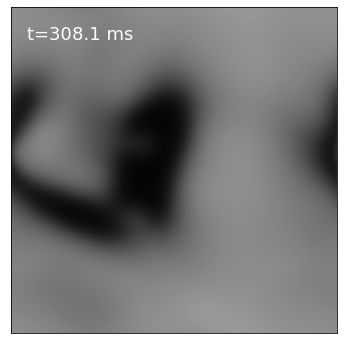

In [47]:
cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
message_string=f'{t=:.1f} ms'
inch=6;
fontsize=18;
vmin_img=-85.;vmax_img=35.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=470, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=100, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.05,.9,message_string,
        horizontalalignment='left',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)

#     ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [54]:
n_series = pd.Series(index=t_lst,data=n_lst)
tbirth_values = n_series[n_series.diff()==2].index.values
tbirth_values

array([144.1, 216.1, 236.1, 272.1, 288.1])

In [55]:
# n_series

# identify a nice creation event

In [188]:
# index=0
# index=1
index=2
tbirth = tbirth_values[index] - 3*dt*nsteps_per_DT
# tbirth = tbirth_values[index] - 2*dt*nsteps_per_DT
# tbirth = tbirth_values[index] - 1.5*dt*nsteps_per_DT
tbirth

224.09999999999087

# identify a frame just before a nice creation event

In [189]:
V_threshold=-40
# V_threshold=-30
# V_threshold=-50
# V_threshold=-20
# V_threshold=-15
level1=V_threshold
level2=V_threshold

In [190]:
#reset time
txt = txt_init.copy()
t = float(t_init)
n = int(n_init)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)

In [191]:
tmax=tbirth
printing=True
while t<tbirth:
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt   
img=inVc[...,0].copy()
img_prev = img.copy()
for step in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img=inVc[...,0].copy()

In [192]:
#compute spiral tip location and topological number
contours_a = find_contours(img,        level = level1)
contours_b = find_contours(img_prev,     level = level2)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
n = len(x_lst)
print(f"{t=:.1f} ms out of {tmax} ms ({n=})", end = printEnd)
# t=234.1 ms out of 230.09999999999087 ms (n=4)

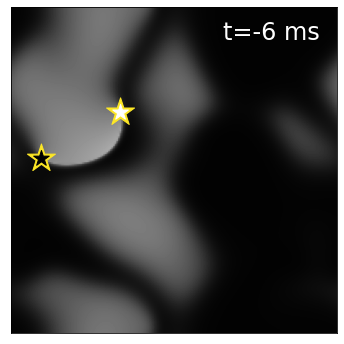

In [193]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[0]=1
# c_values[2]=1

cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=-6 ms'
inch=6;
fontsize=24
vmin_img=-85.;vmax_img=35.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)

# plot_contours_pbc(contours_a,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C0',)
# plot_contours_pbc(contours_b,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C1',)

#     ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# identify a frame just after a nice creation event

In [194]:
img_prev = img
for step in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img=inVc[...,0].copy()

In [195]:
#compute spiral tip location and topological number
contours_a = find_contours(img,        level = level1)
contours_b = find_contours(img_prev,     level = level2)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
n = len(x_lst)
print(f"{t=:.1f} ms out of {tmax} ms ({n=})", end = printEnd)

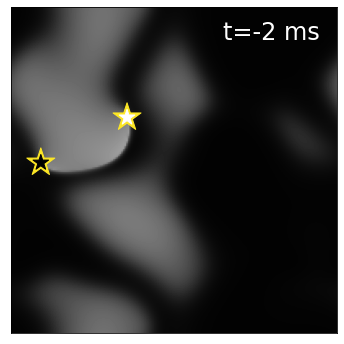

In [196]:
x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[0]=1
# c_values[2]=1

cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=-2 ms'
inch=6;
# fontsize=18;
vmin_img=-85.;vmax_img=35.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)

# plot_contours_pbc(contours_a,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C0',)
# plot_contours_pbc(contours_b,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C1',)

#     ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [197]:
img_prev = img
for step in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img=inVc[...,0].copy()

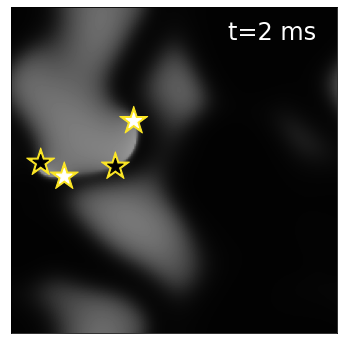

In [198]:

#compute spiral tip location and topological number
contours_a = find_contours(img,        level = level1)
contours_b = find_contours(img_prev,     level = level2)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
n = len(x_lst)
print(f"{t=:.1f} ms out of {tmax} ms ({n=})", end = printEnd)

x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[0]=1
c_values[2]=1

cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=2 ms'
inch=6;
# fontsize=18;
vmin_img=-85.;vmax_img=35.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)

# plot_contours_pbc(contours_a,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C0',)
# plot_contours_pbc(contours_b,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C1',)

#     ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# identify a frame just after ^that snapshot

In [199]:
img_prev = img
for step in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img=inVc[...,0].copy()

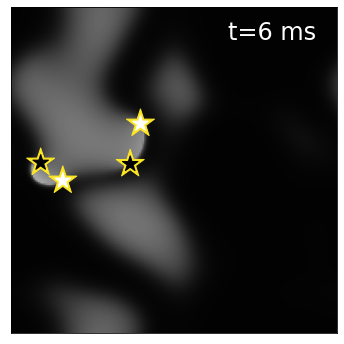

In [200]:

#compute spiral tip location and topological number
contours_a = find_contours(img,        level = level1)
contours_b = find_contours(img_prev,     level = level2)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
n = len(x_lst)
print(f"{t=:.1f} ms out of {tmax} ms ({n=})", end = printEnd)

x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[0]=1
c_values[2]=1

cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=6 ms'
inch=6;
# fontsize=18;
vmin_img=-85.;vmax_img=35.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)

# plot_contours_pbc(contours_a,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C0',)
# plot_contours_pbc(contours_b,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C1',)

#     ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [201]:
img_prev = img
for step in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img=inVc[...,0].copy()

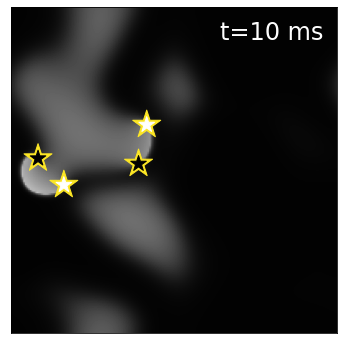

In [202]:

#compute spiral tip location and topological number
contours_a = find_contours(img,        level = level1)
contours_b = find_contours(img_prev,     level = level2)
s1_lst, s2_lst, x_lst, y_lst = contours_to_simple_tips_pbc(contours_a,contours_b,width,height,jump_threshold,size_threshold)
n = len(x_lst)
print(f"{t=:.1f} ms out of {tmax} ms ({n=})", end = printEnd)

x_values=np.array(x_lst)
y_values=np.array(y_lst)
c_values=0*x_values
c_values[0]=1
c_values[2]=1

cmap='bone'
cmap='gray_r'
axis=[0,img.shape[0],0,img.shape[1]]
# message_string=f'{t=:.1f} ms'
message_string=f't=10 ms'
inch=6;
# fontsize=24
vmin_img=-85.;vmax_img=35.
vmin_tips=0.;vmax_tips=1.
textcolor='w'
fig, ax = plt.subplots(figsize=(inch,inch))
# ax.imshow(img, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
ax.imshow(img_prev, cmap=plt.cm.gray,vmin=vmin_img,vmax=vmax_img)
#plot spiral tips. color inner spiral tip by slow variable
ax.scatter(x=x_values, y=y_values, s=870, c=1+0.*c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips)
ax.scatter(x=x_values, y=y_values, s=270, c=c_values, marker='*', zorder=3, alpha=1, vmin=vmin_tips,vmax=vmax_tips, cmap=cmap)
ax.text(.8,.9,message_string,
        horizontalalignment='center',color=textcolor,fontsize=fontsize,
        transform=ax.transAxes)
ax.axis(axis)

# plot_contours_pbc(contours_a,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C0',)
# plot_contours_pbc(contours_b,ax,
#     linewidth=2,min_num_vertices=1,alpha=1.0,
#     linestyle='-',color='C1',)

#     ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [203]:
beep(3)



0